## Import Relevant Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import gensim
import nltk
from nltk.collocations import *
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import RegexpTokenizer 
import pandas as pd

## Import Tweets Data

In [2]:
train_data = pd.read_csv('final_tweets.csv')
train_data

,Datetime,Tweet Id,Text,Username
0,2022-03-04 08:34:06+00:00,1499664468225458180,Regarding this : some statutory board have sel...,JJ_Angelus
1,2022-01-27 09:00:06+00:00,1486625048265834497,Which MBA programme is the best in Singapore? ...,Gyan_One
2,2022-01-27 04:24:15+00:00,1486555627560206336,Pagi ini abis screening hampir 100 CV fresh gr...,Saefullloh
3,2021-12-06 18:06:04+00:00,1467918277884080129,"honestly, really glad i made it to nus bc wthe...",nursyxza
4,2021-09-30 10:10:19+00:00,1443518565466861570,@staronline Does one need training to become a...,PGeorge9601
...,...,...,...,...
553,2011-10-19 06:22:42+00:00,126543777597886464,"Lecturer made some touchy statements, which is...",cxloh
554,2011-06-21 05:51:50+00:00,83049467896532992,Median starting pay for Social Science honours...,leemx
555,2011-05-18 12:32:46+00:00,70829176411787265,We r Singaporean under grad edition. So funny....,punk_hamstar
556,2011-04-28 15:50:34+00:00,63631196717977600,NTU econs vs NUS computing (info sys) vs SMU I...,chaitehlatte


In [3]:
train_text = train_data[['Text']]
train_text

,Text
0,Regarding this : some statutory board have sel...
1,Which MBA programme is the best in Singapore? ...
2,Pagi ini abis screening hampir 100 CV fresh gr...
3,"honestly, really glad i made it to nus bc wthe..."
4,@staronline Does one need training to become a...
...,...
553,"Lecturer made some touchy statements, which is..."
554,Median starting pay for Social Science honours...
555,We r Singaporean under grad edition. So funny....
556,NTU econs vs NUS computing (info sys) vs SMU I...


## Data Cleaning

In [64]:
from deep_translator import GoogleTranslator
# to_translate = 'シンガポールの四大新卒初任給、昨年卒の中央値は$3600(約28万円)、it系学部に限ると$4400(約34.5万円)です。\n統計対象の大学はnus、ntu、smu、sussの4大学です'
# translated = GoogleTranslator(source='auto', target='en').translate(to_translate)
# print(translated)

translated_text = []
for i in range(len(train_text)):
#     print(i)
    translated = GoogleTranslator(source='auto', target='en').translate(train_text.iloc[i, 0])
    translated_text.append(translated)
    print(translated)
#     print(train_text.iloc[i, 0])

regarding this  some statutory board have selected few public individuals to do the survey 

my household was chosen to do them

in fact  smu nus ntu all have given surveys to public individuals who want to participate

so why should our gov release it to the public
which mba programme is the best in singapore 
is it the prestigious insead the muchvaulted nus nanyang or ntu as some call it or the fastgrowing smu have similar questions in mind check out our blog to get all of your questions answered 
mba
this morning, after screening almost 100 cv fresh graduates from ntu nus high school with several polytechnics in singapore, surprisingly there are many graduates from non-it or related engineering majors but in their skill set they have python java c javascript etc.
honestly really glad i made it to nus bc wtheck smu and ntu module bidding mcm nak perang siakaku tengok pun aku stress bodo 😫
staronline does one need training to become an entrepreneur drnorainiahmad
if yes why is it not 

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [15]:
train_text['Text'] = train_text['Text'].str.replace(r'@[^\s]+:', '')
train_text['Text'] = train_text['Text'].str.replace(r'https?://\S+', "")
train_text['Text'] = train_text['Text'].map(lambda x: x.lower())
# train_text['Text'].map(lambda x: x.lower())
train_text['Text'].values

C:\Users\jing_\AppData\Local\Temp/ipykernel_8744/2594776083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_text['Text'] = train_text['Text'].str.replace(r'@[^\s]+:', '')
C:\Users\jing_\AppData\Local\Temp/ipykernel_8744/2594776083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_text['Text'] = train_text['Text'].str.replace(r'https?://\S+', "")
C:\Users\jing_\AppData\Local\Temp/ipykernel_8744/2594776083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

array(['regarding this : some statutory board have selected few public individuals to do the survey. \n\nmy household, was chosen to do them.\n\nin fact : smu, nus, ntu, all have given surveys to public individuals who want to participate.\n\nso why should our gov release it to the public.',
       'which mba programme is the best in singapore? \nis it the prestigious insead, the much-vaulted nus, nanyang (or ntu, as some call it), or the fast-growing smu? have similar questions in mind? check out our blog to get all of your questions answered. \n#mba',
       'pagi ini abis screening hampir 100 cv fresh graduate dari ntu, nus, smu sama beberaapa politeknik di singapore. kagetnya, ada banyak lulusan jurusan yang non it or teknik related, tapi di skill set mereka ada phyton, java, c++, javascript, dll.',
       'honestly, really glad i made it to nus bc wtheck smu and ntu module bidding mcm nak perang siak....aku tengok pun aku stress bodo 😫',
       "@staronline does one need training 

In [11]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.append('ntu')
stop_words.append('smu')
stop_words.append('sim')
stop_words.append('nus')
stop_words.append('sutd')
stop_words.append('amp')
stop_words.append('university')
stop_words.append('universities')
stop_words.append('sit')
stop_words.append('v')
stop_words.append('vs')
stop_words.append('uni')
stop_words.append('singapore')
stop_words.append('u')
stop_words.append('student')
stop_words.append('rt')
stop_words.append('school')
stop_words.append('students')
stop_words.append('schools')
stop_words.append('like')
stop_words.append('go')
stop_words.append('get')
stop_words.append('know')

# WordCloud

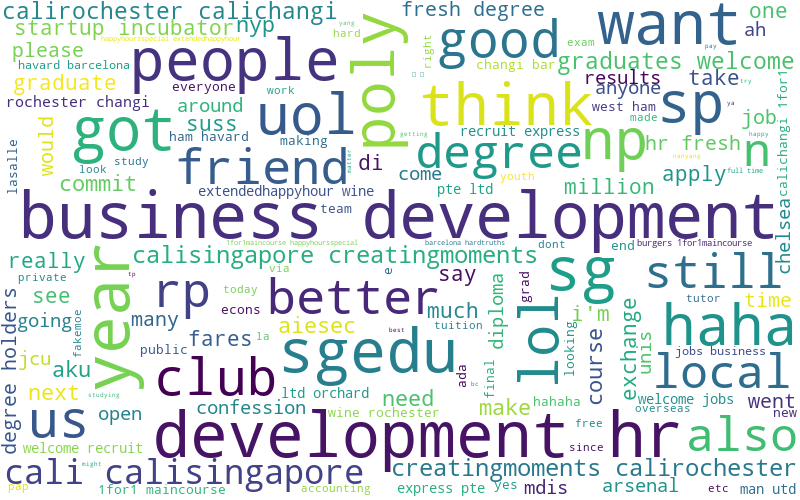

In [12]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(train_text['Text']))
# print(long_string)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500, stopwords=stop_words, background_color="white", max_words=150, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## Topic Modelling

In [16]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = train_text.Text.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
print(data_words)

[['regarding', 'statutory', 'board', 'selected', 'public', 'individuals', 'survey', 'household', 'chosen', 'fact', 'given', 'surveys', 'public', 'individuals', 'want', 'participate', 'gov', 'release', 'public'], ['mba', 'programme', 'best', 'prestigious', 'insead', 'much', 'vaulted', 'nanyang', 'call', 'fast', 'growing', 'similar', 'questions', 'mind', 'check', 'blog', 'questions', 'answered', 'mba'], ['pagi', 'ini', 'abis', 'screening', 'hampir', 'cv', 'fresh', 'graduate', 'dari', 'sama', 'beberaapa', 'politeknik', 'di', 'kagetnya', 'ada', 'banyak', 'lulusan', 'jurusan', 'yang', 'non', 'teknik', 'related', 'tapi', 'di', 'skill', 'set', 'mereka', 'ada', 'phyton', 'java', 'javascript', 'dll'], ['honestly', 'really', 'glad', 'made', 'bc', 'wtheck', 'module', 'bidding', 'mcm', 'nak', 'perang', 'siak', 'aku', 'tengok', 'pun', 'aku', 'stress', 'bodo'], ['staronline', 'one', 'need', 'training', 'become', 'entrepreneur', 'drnorainiahmad', 'yes', 'included', 'part', 'curriculum', 'might', 'wan

In [19]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1][0][:30])

In [22]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"business" + 0.020*"development" + 0.020*"hr" + 0.019*"welcome" + '
  '0.015*"jobs" + 0.012*"graduates" + 0.010*"degree" + 0.008*"recruit" + '
  '0.008*"express" + 0.008*"pte"'),
 (1,
  '0.007*"万円" + 0.007*"平均" + 0.006*"psb" + 0.005*"live" + 0.005*"calling" + '
  '0.004*"aku" + 0.004*"di" + 0.004*"lek" + 0.004*"around" + '
  '0.004*"television"'),
 (2,
  '0.013*"cali" + 0.010*"maincourse" + 0.009*"bar" + 0.008*"rp" + 0.008*"np" + '
  '0.007*"di" + 0.007*"sp" + 0.007*"calirochester" + 0.007*"creatingmoments" + '
  '0.007*"tp"'),
 (3,
  '0.014*"uol" + 0.013*"degree" + 0.010*"tuition" + 0.008*"business" + '
  '0.007*"pap" + 0.006*"diploma" + 0.006*"need" + 0.005*"friends" + '
  '0.005*"people" + 0.005*"poly"'),
 (4,
  '0.008*"haha" + 0.007*"got" + 0.007*"better" + 0.006*"please" + '
  '0.006*"creatingmoments" + 0.006*"maincourse" + 0.006*"lol" + 0.006*"cali" + '
  '0.005*"bar" + 0.005*"tp"'),
 (5,
  '0.011*"got" + 0.007*"public" + 0.006*"econs" + 0.006*"want" + 0.006*"man" +

## Sentiment Analysis

In [ ]:
from nltk.tokenize import RegexpTokenizer #follow this rule to break the sentence.
retokenizer = RegexpTokenizer(r'[\w@]+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()
def process_text(documents):
    processed_docs = []
    doc_tokens = []
    for doc in documents:
#         doc = doc.lower()
#         doc = remove_urls(doc)
        doc_tokens = retokenizer.tokenize(doc) 
        doc_tokens = [token for token in doc_tokens if token not in stop_words]        
        doc_tokens = [wnl.lemmatize(token) for token in doc_tokens]
        #print (doc_tokens)
        #doc = ' '.join(doc_tokens) # form them back as a sentence
    processed_docs.append(doc_tokens)
        #print(doc)
    return processed_docs
for i in train_text['Text']:
    a = process_text(train_text['Text'])
    print(a)

In [24]:
#Cleaning and removing punctuations

import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
train_text['Text']= train_text['Text'].apply(lambda x: cleaning_punctuations(x))
train_text['Text'].tail()

C:\Users\jing_\AppData\Local\Temp/ipykernel_8744/328186223.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_text['Text']= train_text['Text'].apply(lambda x: cleaning_punctuations(x))


553    lecturer made some touchy statements which is ...
554    median starting pay for social science honours...
555    we r singaporean under grad edition so funny n...
556    ntu econs vs nus computing info sys vs smu inf...
557    okayokay im swearing off reading forums about ...
Name: Text, dtype: object

In [25]:
#Cleaning and removing repeating characters

def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
train_text['Text'] = train_text['Text'].apply(lambda x: cleaning_repeating_char(x))
train_text['Text'].tail()

NameError: name 're' is not defined

In [ ]:
#Cleaning and removing Numeric numbers

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
train_text['Text'] = train_text['Text'].apply(lambda x: cleaning_numbers(x))
train_text['Text'].tail()

In [47]:
#Get Tweet Sentiment
from textblob import TextBlob
text = train_text['Text'].values
def get_tweet_sentiment(tweet, sentiments):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(tweet)
        # set sentiment
        if analysis.sentiment.polarity > 0:
            sentiments.append('positive')
#             print('positive')
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            sentiments.append('neutral')
#             print('neutral')
            return 'neutral'
        else:
            sentiments.append('negative')
#             print('negative')
            return 'negative'
sentiments = []
for i in text:
    get_tweet_sentiment(i, sentiments)
#     print(i)
# print(sentiments)

In [48]:
sentiment_df = pd.DataFrame({'sentiments':sentiments})
sentiment_df

,sentiments
0,negative
1,positive
2,positive
3,positive
4,neutral
...,...
553,positive
554,positive
555,positive
556,neutral


In [52]:
overall_df = pd.concat([train_text, sentiment_df.reindex(train_text.index)], axis=1)
overall_df

,Text,sentiments
0,regarding this some statutory board have sele...,negative
1,which mba programme is the best in singapore \...,positive
2,pagi ini abis screening hampir 100 cv fresh gr...,positive
3,honestly really glad i made it to nus bc wthec...,positive
4,staronline does one need training to become an...,neutral
...,...,...
553,lecturer made some touchy statements which is ...,positive
554,median starting pay for social science honours...,positive
555,we r singaporean under grad edition so funny n...,positive
556,ntu econs vs nus computing info sys vs smu inf...,neutral


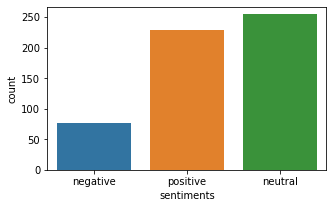

In [53]:
# sentiment_df.plot(kind="bar")
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.countplot(data=overall_df, x='sentiments')
plt.show()